In [ ]:
!pip install --upgrade datasets evaluate transformers==4.46.2 rouge_score accelerate==0.27.2 peft==0.10 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━

In [ ]:
from transformers import (
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
)
from google.colab import drive
from datasets import load_dataset, Dataset
from evaluate import load
import pandas as pd


drive.mount('/content/drive/')

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

Mounted at /content/drive/


In [ ]:
def backup_colab_content_to_drive(folder_name='Colab Notebooks'):
  import shutil
  import os

  src = '/content'
  dest = f'/content/drive/MyDrive/{folder_name}'
  os.makedirs(dest, exist_ok=True)

  for item in os.listdir(src):
    if item == 'drive':
      continue
    s = os.path.join(src, item)
    d = os.path.join(dest, item)
    if os.path.isdir(s):
      shutil.copytree(s, d)
    else:
      shutil.copy2(s, d)

  print(f'📁 Backup complete. Files saved to: {dest}')

In [ ]:
file_path = "/content/drive/MyDrive/robot_dreams/final/sum_data.pickle"
df = pd.read_pickle(file_path)
df.head(2)

,text,summary
0,multiscale dynamics is present in many phenome...,the classical structure - function ( sf ) met...
1,a fair number of astronomers and astronomy stu...,making online resources more accessible to ph...


Text median 27427, 75 percentile 39939.5, 90 percentile 54361.399999999994
Summary median 990, 75 percentile 1366.0, 90 percentile 1691.7999999999993


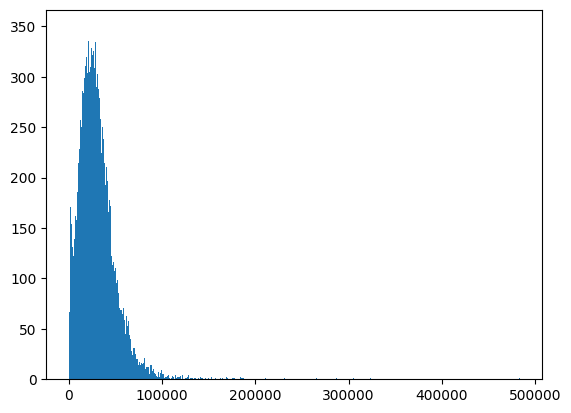

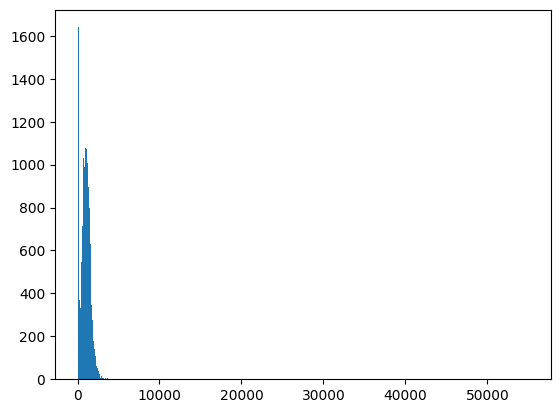

In [ ]:
from statistics import median, mode
import matplotlib.pyplot as plt
import numpy as np

text_len = [len(x) for x in df['text']]
print(f'Text median {median(text_len)}, 75 percentile {np.percentile(text_len, 75)}, 90 percentile {np.percentile(text_len, 90)}')
sum_len = [len(x) for x in df['summary']]
print(f'Summary median {median(sum_len)}, 75 percentile {np.percentile(sum_len, 75)}, 90 percentile {np.percentile(sum_len, 90)}')

plt.hist(text_len, bins=1000)
plt.show()

plt.hist(sum_len, bins=1000)
plt.show()

In [ ]:
dataset = Dataset.from_pandas(df.sample(100))\
  .shuffle()\
  .train_test_split(test_size=0.1)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', '__index_level_0__'],
        num_rows: 90
    })
    test: Dataset({
        features: ['text', 'summary', '__index_level_0__'],
        num_rows: 10
    })
})

In [ ]:
train_dataset = dataset['train']
val_dataset = dataset['test']

In [ ]:
MODEL_NAME = "allenai/led-base-16384"
MAX_INPUT_LENGTH = 30208
MAX_TARGET_LENGTH = 100
BATCH_SIZE = 2

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(
    batch["text"],
    padding="max_length",
    truncation=True,
    max_length=MAX_INPUT_LENGTH,
  )
  outputs = tokenizer(
    batch["summary"],
    padding="max_length",
    truncation=True,
    max_length=MAX_TARGET_LENGTH,
  )

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask

  # create 0 global_attention_mask lists
  batch["global_attention_mask"] = len(batch["input_ids"]) * [
    [0 for _ in range(len(batch["input_ids"][0]))]
  ]

  # since above lists are references, the following line changes the 0 index for all samples
  batch["global_attention_mask"][0][0] = 1
  batch["labels"] = outputs.input_ids

  # We have to make sure that the PAD token is ignored
  batch["labels"] = [
    [-100 if token == tokenizer.pad_token_id else token for token in labels]
    for labels in batch["labels"]
  ]

  return batch

In [ ]:
train_dataset = train_dataset.map(
  process_data_to_model_inputs,
  batched=True,
  batch_size=BATCH_SIZE,
  remove_columns=["text", "summary", "__index_level_0__"],
)
val_dataset = val_dataset.map(
  process_data_to_model_inputs,
  batched=True,
  batch_size=BATCH_SIZE,
  remove_columns=["text", "summary", "__index_level_0__"],
)

train_dataset.set_format(
  type="torch",
  columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
  type="torch",
  columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
led = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, gradient_checkpointing=True, use_cache=False)

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
# set generate hyperparameters
led.config.num_beams = 2
led.config.max_length = 512
led.config.min_length = 100
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

In [ ]:
rouge = load("rouge")

model.safetensors:   0%|          | 0.00/648M [00:00<?, ?B/s]

In [ ]:
def compute_metrics(pred):
  labels_ids = pred.label_ids
  pred_ids = pred.predictions

  pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
  labels_ids[labels_ids == -100] = tokenizer.pad_token_id
  label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

  rouge_output = rouge.compute(
    predictions=pred_str, references=label_str, rouge_types=["rouge2"]
  )["rouge2"].mid

  return {
    "rouge2_precision": round(rouge_output.precision, 4),
    "rouge2_recall": round(rouge_output.recall, 4),
    "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
  }

In [ ]:
training_args = Seq2SeqTrainingArguments(
  predict_with_generate=True,
  evaluation_strategy="steps",
  per_device_train_batch_size=BATCH_SIZE,
  per_device_eval_batch_size=BATCH_SIZE,
  fp16=True,
  output_dir="./",
  logging_steps=5,
  eval_steps=10,
  save_steps=10,
  save_total_limit=2,
  gradient_accumulation_steps=4,
  num_train_epochs=1,
)

trainer = Seq2SeqTrainer(
  model=led,
  tokenizer=tokenizer,
  args=training_args,
  compute_metrics=compute_metrics,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-9732583ee923>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
import gc

gc.collect()

2518

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: daryayu (daryayu-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Input ids are automatically padded from 30208 to 30720 to be a multiple of `config.attention_window`: 1024
